# Alignment Plots

This notebook makes the plots for the alignment documentation page.

In [1]:
import proplot as plot
import xarray as xr
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects

Create sample array with numeric time.

In [2]:
leads = np.arange(4)
inits  = plot.arange(1990, 2000)
obstime = plot.arange(1995, 2002)

forecast = xr.DataArray(np.random.rand(len(leads), len(inits)),
                  dims=['lead', 'time'],
                  coords=[leads, inits])
verif = xr.DataArray(np.random.rand(len(obstime)),
                     dims=['time'], coords=[obstime])

Check for plot:

```python
from climpred.utils import convert_time_index
from climpred.alignment import return_inits_and_verif_dates

forecast = convert_time_index(forecast, 'time', '')
verif = convert_time_index(verif, 'time', '')

inits, verifs = return_inits_and_verif_dates(forecast, verif, 'same_verifs')
print(inits)
print(verifs)
```

Make init_lead_matrix as in code.

In [3]:
init_lead_matrix = xr.concat([forecast.time + int(l) for l in forecast.lead.values], 'lead')
init_lead_matrix['lead'] = np.arange(4)

In [4]:
init_lead_matrix

<xarray.DataArray 'time' (lead: 4, time: 11)>
array([[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000],
       [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001],
       [1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002],
       [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]])
Coordinates:
  * time     (time) int64 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
  * lead     (lead) int64 0 1 2 3

In [5]:
# Need two dimensions to plot pcolor for the verification time series.
pv = verif.expand_dims({'lead': 2})
pv = xr.ones_like(pv)
pv[:] = pv.time

/Users/ribr5703/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/proplot/utils.py:135: UserWarning: Got conflicting or duplicate keyword args: {'color': 'k', 'edgecolor': 'w'}. Using the first one.
  f'Got conflicting or duplicate keyword args: {kwargs}. '
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


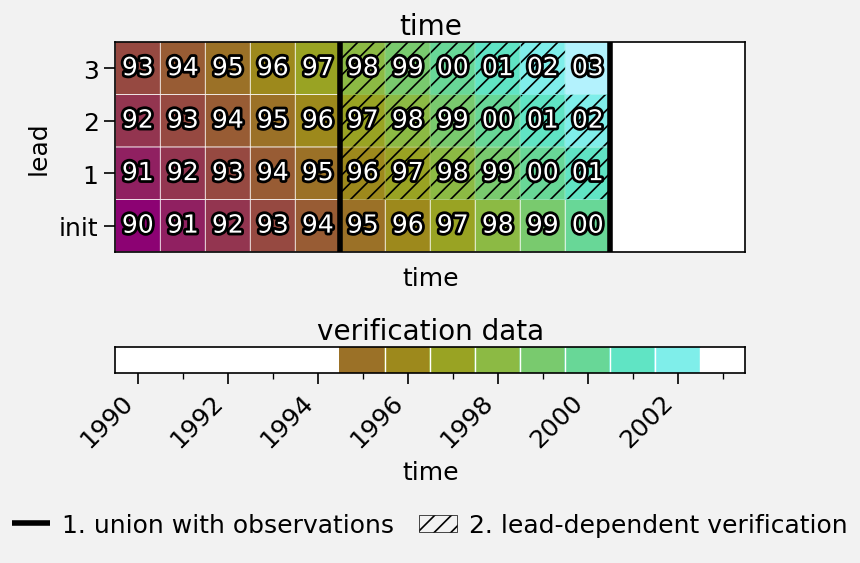

In [6]:
plot.rc.fontname = 'Helvetica'

LEVELS = plot.arange(min(inits)-1, max(obstime)+1, 1)
CMAP = 'hawaii'

f, axs = plot.subplots(nrows=2, hratios=[8, 1], spany=False,
                       axwidth='8cm', aspect=3, sharex=False)

p = axs[0].pcolor(init_lead_matrix.time,
          init_lead_matrix.lead,
          init_lead_matrix,
          cmap=CMAP,
          edgecolor='w',
          levels=LEVELS)

axs[0].format(title='initialized forecasting system', ylabel='lead year',
              yticks=plot.arange(0, 4), 
#               xlabel='initialization year',
              xlabel='',
              ytickminor=False,
              yticklabels=['init', '1', '2', '3'],
              xticklen=0,
              xticks='null')

# Label init_lead matrix
for x in inits:
    for y in (leads):
        val = str(x + y)[-2::]
        txt = axs[0].text(x, y, val, color='w', ha='center', va='center')
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
        
conditions = (init_lead_matrix >= 1995) & (init_lead_matrix <= 2002) & (init_lead_matrix.time >= 1995) & (init_lead_matrix.lead > 0)
p = axs[0].pcolor(init_lead_matrix.time,
              init_lead_matrix.lead,
              init_lead_matrix.where(conditions),
              hatch='////',
              edgecolor='w',
              facecolor='None',
              color='k',
              cmap=CMAP,
              levels=LEVELS,
              label='2. lead-dependent verification')


p2 = axs[0].vlines([1994.5, 2000.5], [-0.5, -0.5], [3.5, 3.5],
              color='k', linewidth=2, label='1. union with observations')

# Verification time series
axs[1].pcolor(pv.time, pv.lead, pv,
              cmap=CMAP,
              levels=LEVELS)
axs[1].format(yformatter='null', yticklen=0, title='verification data',
              ylabel='', xlabel='time',)

axs[1].vlines([i + 0.5 for i in plot.arange(pv.time.min(), pv.time.max())],
              -0.5, 1.5, color='w', linewidth=0.5)

axs.format(xlim=(1989.5, 2003.5),
           xminorlocator=1,
           xrotation=45,)

f.legend([p2, p], loc='b', frameon=False)

f.savefig('maximize_alignment.png', dpi=300)